# Red or blue galaxies?

### By: [Natalí S. M. de Santi](https://natalidesanti.github.io)

In this notebook we will see how to predict if a galaxy is **red** or **blue** using some galaxy properties and a ML method called **Random Forest** (RF)

## Summary

1) Running options
2) Motivation
3) Libraries required
4) Handling data
5) Random Forest

## 1) Running options

* **On the fly:** you can easily open it in `google colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/natalidesanti/ML4cosmology/blob/main/notebooks/redXblue.ipynb)
* **On your won computer:** you can download the notebook and work on this. Just make sure you have all the libraries installed

## 2) Motivation

One of the main galaxies properties is **color**, due to the fact that we primary measure galaxy **magnitudes** (a measure of luminosity),
what composes the well-known **galaxy color-magnitude diagram**:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Galaxy_color-magnitude_diagram-en.svg/300px-Galaxy_color-magnitude_diagram-en.svg.png)
###### [Image source: [Wikipedia](https://en.wikipedia.org/wiki/Galaxy_color–magnitude_diagram)]

Galaxy color is a way to start describing a bunch of other galaxy properties: e.g. _red galaxies_ are tipically _elliptical_, while _blue_ galaxies are tipically _spirals_.

If you are interested on knowing more about galaxy properties, take a look at these amazing papers:

* Donnary et al. [arXiv:1812.07584](https://arxiv.org/abs/1812.07584)
* Bell et al. [arxiv:0303394](https://arxiv.org/abs/astro-ph/0303394)
* Conselice et al. [arXiv:0610016](https://arxiv.org/abs/astro-ph/0610016)

## 3) Libraries required

Many of these libraries can be installed using the following command line:

`pip install name_of_the_library`


Fell free to reach me out if you do not get enough resources online, regarding their installation.

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import tree
from cmap import Colormap

## 4) Handling data

First things first, what is the dataset we are going to use?

It is a [IllustrisTNG](https://www.tng-project.org) box from a single snapshot (z = 0) from the [CAMELS]((https://camels.readthedocs.io/en/latest/)) simulations.
A complete description of the simulations and data, as well how to download more data, is given in the CAMELS [webpage](https://camels.readthedocs.io/en/latest/subfind.html) documentation page.

### 4.1) Getting and analysing the data

We can download the data using:

In [5]:
!wget -q -nc -O ../data/fof_subhalo_tab_033.hdf5 https://www.dropbox.com/scl/fi/nkbxz27del5iias8fgatl/fof_subhalo_tab_033.hdf5?rlkey=sigrg4t7tpjmq86x8ub8lsjls&st=z5x76tlk&dl=0

zsh:1: parse error near `&'


**IllustrisTNG** data is a `.hdf5` file. 
We can read the content using the library `h5py`. 
We use the `with` method to ensure that the file is properly opened and closed each time we access it, and specify the `r` to make it clear we are *reading* from the file, not writing. 
We can see what the top level groups and datasets are using the `keys` method:

In [6]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


The cosmological information used to run this simulation can be obtained using:

In [4]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    BoxSize      = f['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
    redshift     = f['Header'].attrs[u'Redshift']       #reshift of the snapshot
    scale_factor = f['Header'].attrs[u'Time']           #scale factor
    h            = f['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
    Omega_m      = f['Header'].attrs[u'Omega0']         #Omega_matter
    Omega_L      = f['Header'].attrs[u'OmegaLambda']    #Omega_baryon

In [5]:
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)
print('Omega_m:                  %.3f'%Omega_m)
print('Omega_L:                  %.3f'%Omega_L)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.00
Omega_m:                  0.300
Omega_L:                  0.700


Apart from the specifications, the catalogs contain two main groups:

* **Group:** contains the properties of the halos.

* **Subhalos:** contains the properties of the subhalos. Galaxies, are considered as subhalos with stellar mass larger than 0.

In this tutorial we are going to work only with the galaxies. So, le't get some of their properties.

In [6]:
with h5py.File('../data/fof_subhalo_tab_033.hdf5', 'r') as f:
    SM    = f['/Subhalo/SubhaloMassType'][:, 4]*1e10 #Msun/h
    mags = f['Subhalo/SubhaloStellarPhotometrics'][:]
    SFR = f['Subhalo/SubhaloSFR'][:]*1e10 #(Msun/year)/ (10^10 Msun/h)
    R_g  =  f['Subhalo/SubhaloHalfmassRadType'][:, 4] #kpc/h

Let's select only galaxies with a certain **stellar mass** and convert zero star forming galaxies:

In [7]:
threshold = 1.e8

In [8]:
indexes = np.where(SM > threshold)[0]
SM      = SM[indexes]
mags    = mags[indexes]
SFR     = SFR[indexes]
R_g     = R_g[indexes]
indexes.shape

(860,)

In [9]:
SFR[np.where(SFR == 0)[0]] = 10**(8)

IllustrisTNG comes with 8 magnitude bands: U, B, V, K, g, r, i, z.
Here we will work with the color g - r:

In [10]:
color = mags[:, 4] - mags[:, 5]

According to Donnary (2018) we can split the color diagram according to a threshold of 0.6, separating blue and red galaxies:

Text(0.5, 1.0, 'Galaxy color')

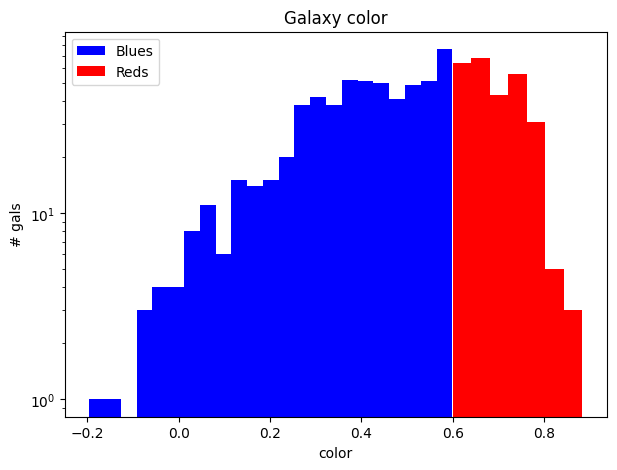

In [11]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.hist(color[np.where(color < 0.6)[0]], bins = 23, color = 'blue', label = 'Blues')
plt.hist(color[np.where(color > 0.6)[0]], bins = 7, color = 'red', label = 'Reds')
plt.yscale('log')
plt.ylabel('# gals')
plt.xlabel('color')
plt.legend()
plt.title('Galaxy color')

Because we only have the colors without any label indicating the galaxy is **blue** or **red**, let's convert this now:

In [12]:
color[np.where(color < 0.6)[0]] = int(0) #Blue
color[np.where(color > 0.6)[0]] = int(1) #Red

Then, we can finally have the data arranged as a `pandas` **dataset**

In [13]:
#Galaxy catalog
data = np.array( [ np.log10(SM), color, np.log10(SFR), R_g ] ).T
columns = [ 'SM', 'color', 'SFR', 'R' ] 
gals = pd.DataFrame(data = data, columns = columns)
gals.head(3)

,SM,color,SFR,R
0,11.630214,1.0,8.000000,30.098984
1,10.379946,0.0,10.230370,3.347014
2,10.190658,0.0,9.343358,4.301775


And the general statistics from these galaxies are:

In [14]:
gals.describe()

,SM,color,SFR,R
count,860.000000,860.000000,860.000000,860.000000
mean,9.006678,0.313953,8.747816,4.378883
std,0.766523,0.464368,0.752413,2.179333
min,8.000628,0.000000,7.499816,0.358295
25%,8.341695,0.000000,8.000000,3.064089
50%,8.849222,0.000000,8.639319,3.973066
75%,9.545236,1.000000,9.395308,5.232606
max,11.630214,1.000000,10.878436,30.098984


Another way to see these other galaxies properties is through their plot:

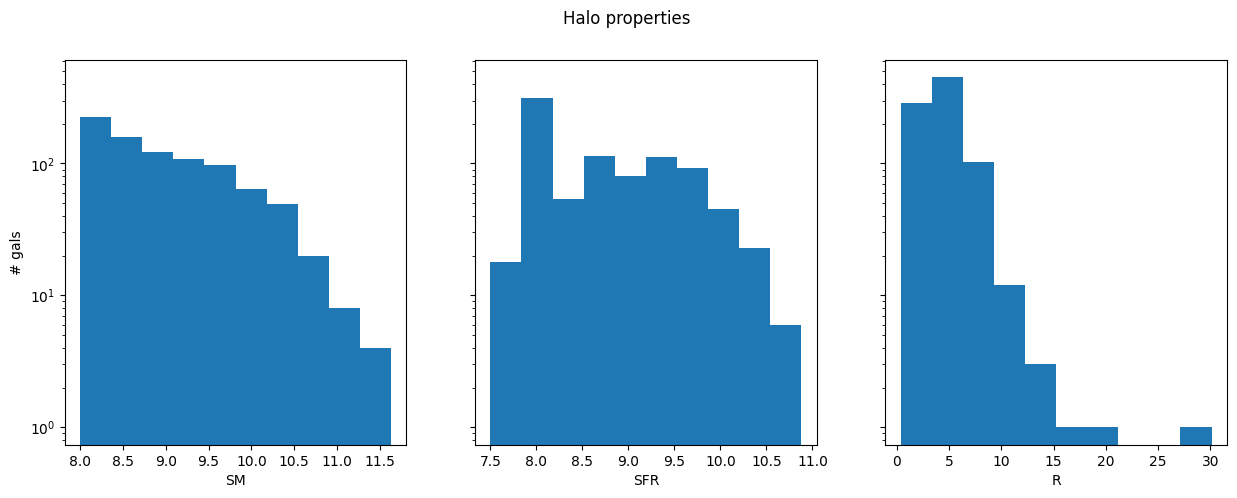

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(gals['SM'])
axs[0].set_xlabel('SM')
axs[0].set_ylabel('# gals')
axs[0].set_yscale('log')

axs[1].hist(gals['SFR'])
axs[1].set_xlabel('SFR')
axs[1].set_yscale('log')

axs[2].hist(gals['R'])
axs[2].set_xlabel('R')
axs[2].set_yscale('log')

### 4.2) Measuring the correlation among the galaxy properties

Here we are going to measure the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
\begin{equation}
 PCC = \frac{ \mathrm{cov} (X, Y) }{ \sigma_X \sigma_Y }
\end{equation}

and plot it as a heatmap of the values.

In [16]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.6f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

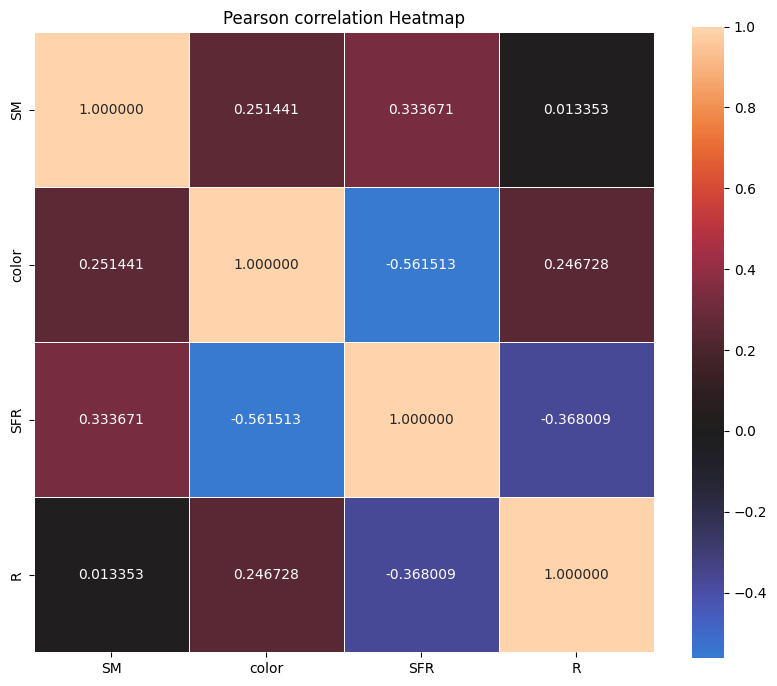

,SM,color,SFR,R
SM,1.000000,0.251441,0.333671,0.013353
color,0.251441,1.000000,-0.561513,0.246728
SFR,0.333671,-0.561513,1.000000,-0.368009
R,0.013353,0.246728,-0.368009,1.000000


In [17]:
correlation_heatmap(gals)

We can see that galaxy colors are well correlated to SFR and stellar mass, while we have a small correlation with their radius.

### 4.3) Machine learning data-pre process

First, let's suffle the data:

In [18]:
gals = gals.sample(frac = 1)

Second, let's select the input (X) and the output or predicted features (y):

In [19]:
X = np.array([gals['SM'], gals['SFR'], gals['R']]).T
y = np.array(gals['color'])
X.shape, y.shape

((860, 3), (860,))

Third, we need to split the data into **training** and **testing** sets:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Third, we can transform the data acconding to:
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std} .
\end{equation}
This transformation is done to constrain the range of all the input variables to small and similar values.

In [21]:
#Preparing data
mean_data = np.mean(X_train, axis = 0)
std_data = np.std(X_train, axis = 0)
mean_data, std_data

(array([9.016256 , 8.7396755, 4.40589  ], dtype=float32),
 array([0.7736276, 0.752343 , 2.1911817], dtype=float32))

In [22]:
X_train -= mean_data
X_train /= std_data
X_test -= mean_data
X_test /= std_data

## 5) Random Forests

At this time we are going to use **Random Forests** to solve this _classification problem_.

### 5.1) Decision Trees

Before talking about them, we first have to take a look at their core, the **Decision Trees** (DT):

![](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/df/de/Decision-Tree.png)
##### [Image source: [IBM](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/cdp/cf/ul/g/df/de/Decision-Tree.png)]

The initial **node**, known as the root node, contains the entire data set. 
At each branch of the tree, the data is partitioned into two child nodes, or subsets, based on a predefined decision boundary. 
One node holds data below the boundary, while the other contains data above it. 
This splitting process recurs until a predefined stopping criterion is met. 
The **leaf nodes** represent the _final decision_ or _prediction_.

A DT is constructed by selecting a feature and defining a value to split the data. 
If we base this criterion on the _information content_ of the data set, we can define the **entropy** E as:
\begin{equation}
 E (x) = - \sum_i p_i (x) \ln [p_i (x)]
\end{equation}
where $x$ represents the data set, $i$ is the class, and $p_i (x)$ the probability of that class, given the training data.

Another usefull quantity defined in terms of this criterion is the **information gain** (IG), which corresponds to the 
reduction in entropy due to the split. 
Essentially, it represents the difference between the entropy of the parent node and the sum of entropies of the child nodes
\begin{equation}
 IG (x) = E (x) - \sum_{i = 0}^1 \frac{N_i}{N} E (x_i)
\end{equation}
where we consider a binary split with $i = 0$ representing the points below the split criteria, and $i = 1$ representing the ones above it.
$N_i$ is the number of points $x_i$ in the $i$-th class, and $E (x_i)$ is the entropy of that class.
Then, the value of the feature to split the data (the **threshold**) is defined by _maximizing the information gain_ for a given split point $s$. 

If a **stopping criterion** is not defined, the tree could continue growing until there is only a single point per node in the splitting set. 
This is highly computationally expensive and usually leads to _overfitting_. 
Therefore, the **stopping criterion** is often defined as _pruning the tree_ or _limiting its depth_, thus also _limiting its complexity_.

### 5.2) Random Forests

They expand the concept of DTs.

First, they generate a set of DTs by **bootstrap samples** (a random subset of the data is created by sampling with replacement).

Second, they consider a _random subset_ of features at each _split_, instead of considering all features (as DTs), and selecting the _best_ one per _split_ based on optimizinf a threshold.

Third, the final task, _classification_ or _regression_, involves determining the majority or averaging the results of the individual DTs, respectively.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*R3oJiyaQwyLUyLZL-scDpw.png)
##### [Image source: [link](https://miro.medium.com/v2/resize:fit:720/format:webp/1*R3oJiyaQwyLUyLZL-scDpw.png)]

This method addresses two limitations of DTs: 
* overfitting the data, as trees are now shorter
* limited extrapolation capability, as it explores the correlation of different features and nonlinear decision boundaries by combining
the predictions of multiple decision trees, each trained on different subsets of data and features in data sets.

These methods are straightforward and intuitive to interpret!

### 5.1) Defining the model

Let's define a simple RF according to:

In [23]:
model = RandomForestClassifier(n_estimators = 20, criterion = "entropy", max_depth = 16, bootstrap = True, random_state = 42, class_weight = 'balanced')

Fitting the model to the training data:

In [24]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, n_estimators=20, random_state=42)

### 5.2) Visualizing the model

We can now visualize each one of the individual trees:

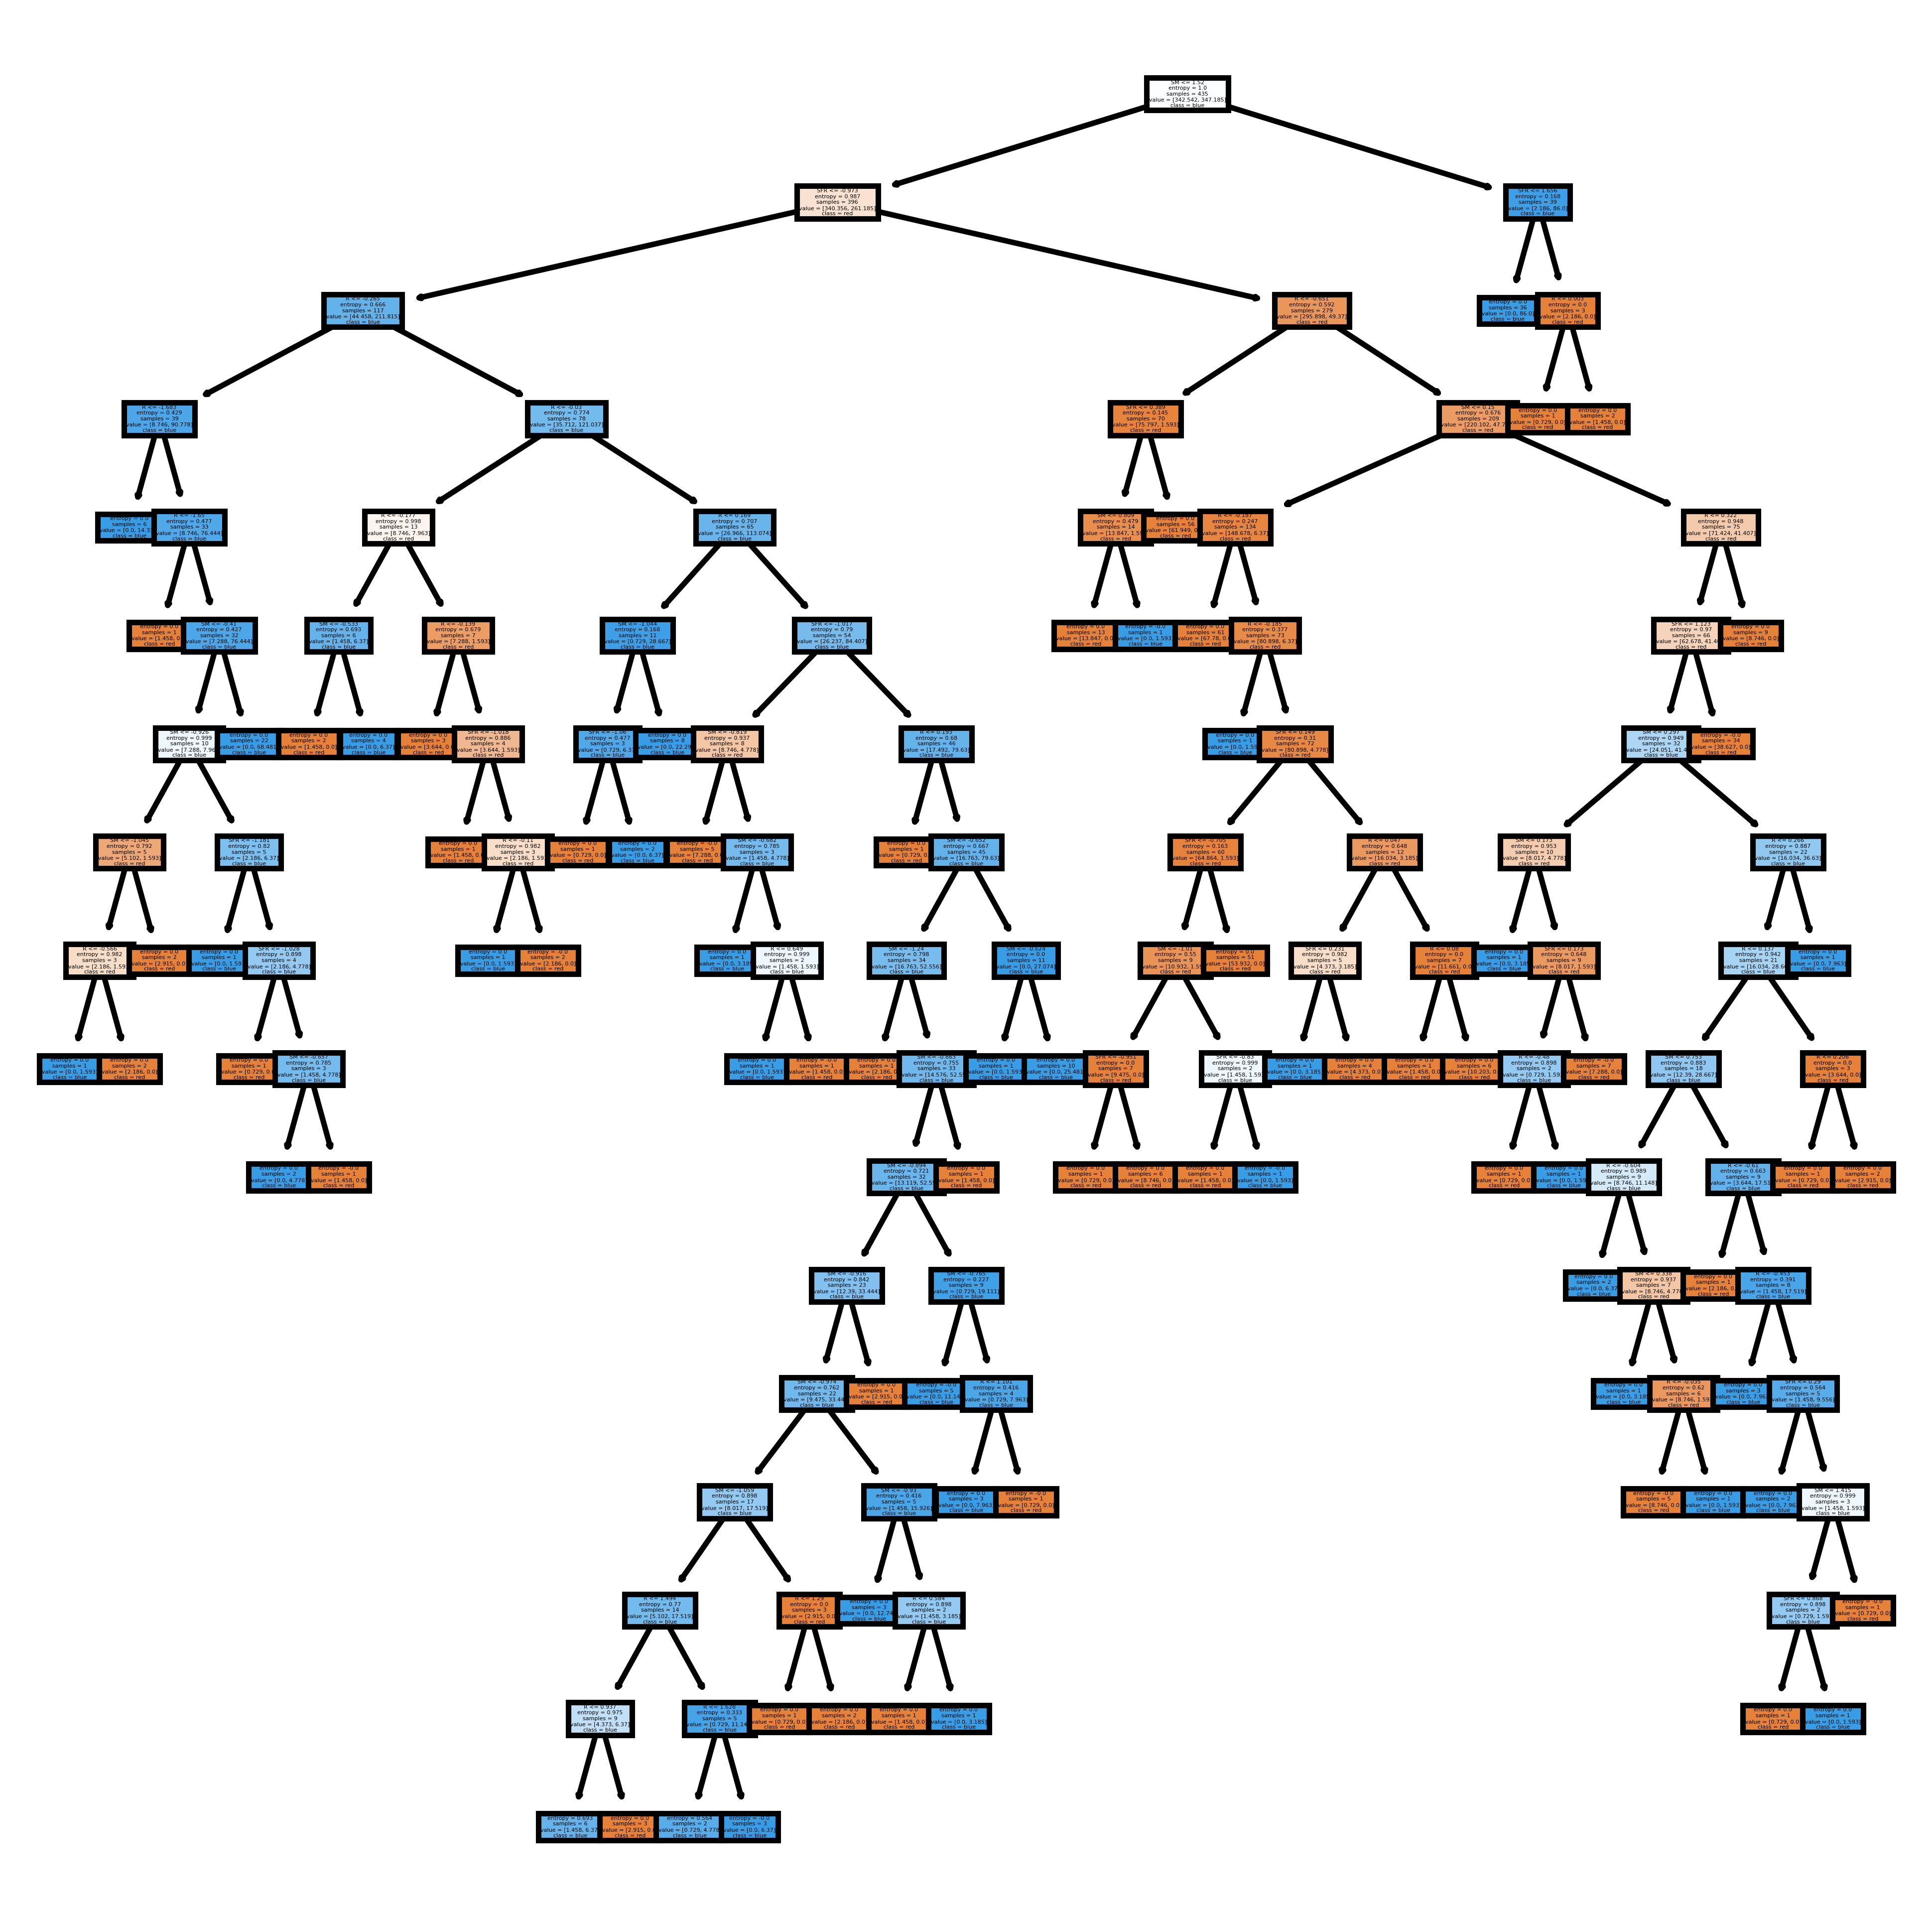

In [25]:
fn = ['SM', 'SFR', 'R']
cn = ['red', 'blue']

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6), dpi = 800)
tree.plot_tree(model.estimators_[0], feature_names = fn, class_names = cn, filled = True);

You can also plot the other trees to explore their differences!

### 5.3) Feature Importance

The FI can be determined by examining _how much_ each feature **increases information gain** when it is used to split nodes in the tree. 
Features that lead to significant _gains in information_ are considered **more important**. 
The **importance** of a feature can be _computed_ by _summing the gains in information over all nodes where the feature is used for splitting_, weighted by the
number of samples in each node.

In [26]:
FI = model.feature_importances_

Text(0.5, 0, 'feature importance')

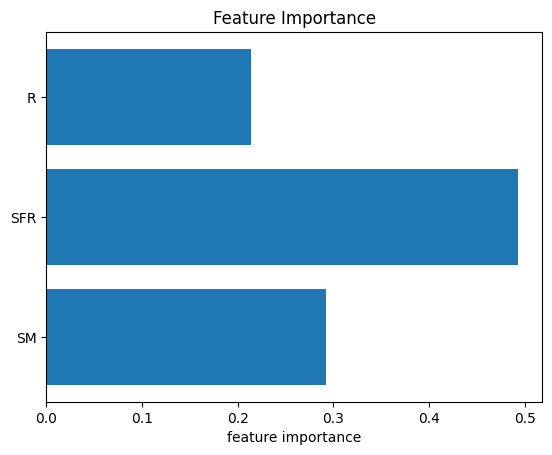

In [27]:
plt.figure(dpi = 100)
plt.title('Feature Importance')
plt.barh(['SM', 'SFR', 'R'], FI)
plt.xlabel('feature importance')

As indicated by the correlation information, the most important feature is SFR, followed by stellar mass, and the galaxy radius.

### 5.4) Predictions

In [28]:
pred = model.predict(X_test)

### 5.5) Checking the model performance

In [29]:
#Evaluating the model
accuracy = accuracy_score(pred, y_test)
precision = precision_score(pred, y_test)
recall = recall_score(pred, y_test)
f1 = f1_score(pred, y_test)
roc_auc = roc_auc_score(pred, y_test)
cm = confusion_matrix(pred, y_test)

In [32]:
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.9012
Precision: 0.7963
Recall: 0.8776
F1-Score: 0.8350
ROC AUC Score: 0.8941


Let's get some intuition of each of these metrics:
* **Accuracy:** measure the overall correctness of the model
\begin{equation}
 A = \frac{TP + TN}{TP + FN + TN + FP}
\end{equation}
* **Precision:** measure how many results are actually correct (minimizing false positives)
\begin{equation}
 P = \frac{TP}{TP + FP}
\end{equation}
* **Recall:** measure how many results are predicted correctly (minimizing false negatives)
\begin{equation}
 R = \frac{TP}{TP + FN}
\end{equation}
* **F1 score:** harmonic mean of precision and recall
\begin{equation}
 F1 = \frac{2 \times P \times R}{P + R}
\end{equation}
* **ROC AUC score:** a number that summarizes the classifier's performance distinguishing between the two classes, measuring the area under curve of a plot of TP and FP

Because all of the above results are close to one ($\gtrapprox 0.8$), the model is good!

Text(0.5, 23.52222222222222, 'Predicted')

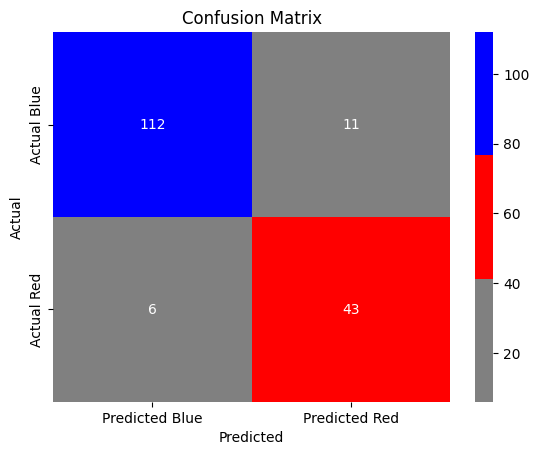

In [31]:
#Confusion matrix
plt.figure(dpi = 100)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot = True, fmt = 'd', cmap = ['gray', 'red', 'blue'], 
            xticklabels = ['Predicted Blue', 'Predicted Red'], yticklabels = ['Actual Blue', 'Actual Red'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

Then, the confusion matrix is telling us that we have less than tens of FP and FN, with a higher number of right predictions!